# NFL Verse Analysis

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import seaborn as sns

In [27]:
# Run only once to download the data then commment out.
years = range(2010, 2025)

# Get the injury data
injuries = nfl.import_injuries(years)

In [28]:
injuries.head()

,season,game_type,team,week,gsis_id,position,full_name,first_name,last_name,report_primary_injury,report_secondary_injury,report_status,practice_primary_injury,practice_secondary_injury,practice_status,date_modified
0,2010.0,REG,ARI,1.0,00-0027007,RB,Chris Wells,Chris,Wells,Knee,None,Questionable,Knee,None,Did Not Participate In Practice,2010-09-10 12:13:53+00:00
1,2010.0,REG,ARI,1.0,00-0022288,RB,Jason Wright,Jason,Wright,Toe,None,Questionable,Toe,None,Limited Participation in Practice,2010-09-10 12:13:44+00:00
2,2010.0,REG,ARI,1.0,00-0025668,CB,Michael Adams,Michael,Adams,Shoulder,None,Probable,Shoulder,None,Full Participation in Practice,NaT
3,2010.0,REG,ARI,1.0,00-0026939,LB,Will Davis,Will,Davis,Knee,None,Probable,Knee,None,Full Participation in Practice,NaT
4,2010.0,REG,ARI,1.0,00-0022921,WR,Larry Fitzgerald,Larry,Fitzgerald,Knee,None,Probable,Knee,None,Full Participation in Practice,NaT


Get more datatets to combine with injuries.

In [29]:
# # Get the play-by-play data
# pbp = nfl.import_pbp_data(years, downcast=True, cache=False, alt_path=None)

# # Schedule
# s = nfl.import_schedules(years)

Store the data for future reference, and not have to re-download it.

In [30]:
# injuries.to_csv('../data/raw/NFL_verse_injuries.csv', index=False)
# pbp.to_csv('../data/raw/NFL_verse_pbp.csv', index=False)
# s.to_csv('../data/raw/NFL_verse_schedule.csv', index=False)

RUN ONLY IF DATA ALREADY EXISTS

In [31]:
# injuries = pd.read_csv('../data/raw/NFL_verse_injuries.csv', low_memory=False)
pbp = pd.read_csv('../data/raw/NFL_verse_pbp_data.csv')
s = pd.read_csv('../data/raw/NFL_verse_schedules.csv')

KeyboardInterrupt: 

In [ ]:
print(f"Injuries has {injuries.shape[0]} rows and {injuries.shape[1]} columns")
print(f"PBP has {pbp.shape[0]} rows and {pbp.shape[1]} columns")
print(f"Schedule has {s.shape[0]} rows and {s.shape[1]} columns")

Injuries has 79863 rows and 16 columns
PBP has 672072 rows and 390 columns
Schedule has 3793 rows and 46 columns


Create a dict of schedule to create the game_id in the injuries data.

In [ ]:
s[['season', 'week', 'home_team', 'away_team', 'game_id']].head()

,season,week,home_team,away_team,game_id
0,2010,1,NO,MIN,2010_01_MIN_NO
1,2010,1,BUF,MIA,2010_01_MIA_BUF
2,2010,1,CHI,DET,2010_01_DET_CHI
3,2010,1,HOU,IND,2010_01_IND_HOU
4,2010,1,JAX,DEN,2010_01_DEN_JAX


Run only once to get the game_id for each injury

In [ ]:
# # Create a dict of schedule to create the game_id in the injuries data, get the year, week, home and away team
# schedule_dict = {}

# for index, row in s.iterrows():
#   schedule_dict[row['game_id']] = {
#     'season': row['season'],
#     'week': row['week'],
#     'home_team': row['home_team'],
#     'away_team': row['away_team']
#   }

# # The injury data does not have game_id, so we need to create it using the schedule data
# # It only has season, week, and the team that the player played for
# injuries['game_id'] = 'unknown'  # Initialize game_id column

# for index, row in injuries.iterrows():
#   for game_id, game_info in schedule_dict.items():
#     if (game_info['season'] == row['season'] and
#       game_info['week'] == row['week'] and
#       (game_info['home_team'] == row['team'] or game_info['away_team'] == row['team'])):
#       row['game_id'] = game_id
#       break  # Stop searching once a match is found
#   injuries.loc[index, 'game_id'] = row['game_id']


In [ ]:
# injuries.to_csv('../data/processed/NFL_verse_injuries_with_game_id.csv', index=False)

ONLY AFTER RUNNING THE ABOVE CODE ONE

In [36]:
injuries = pd.read_csv('../data/processed/NFL_verse_injuries_with_game_id.csv', low_memory=False)

## Clean the injuries data

Rename columns and select only the columns we need.

In [44]:
injuries_renamed = injuries.rename(columns={
    'gsis_id': 'player_id',
    'report_primary_injury': 'injury_body_part',
    'report_status': 'severity'
})[['game_id', 'player_id', 'injury_body_part', 'severity', 'position']]

injuries_renamed['injury_body_part'] = injuries_renamed['injury_body_part'].str.lower()
len(injuries_renamed)

79863

In [45]:
# If there are more than 2 injuries for the same player in the same game, we will keep the first one
injuries_renamed = injuries_renamed.groupby(['game_id', 'player_id']).first().reset_index()
len(injuries_renamed)

75097

In [47]:
print(injuries_renamed['injury_body_part'].value_counts())

injury_body_part
knee                   9214
ankle                  7400
hamstring              5462
shoulder               3768
concussion             2606
                       ... 
facial laceration         1
shoulder, finger          1
shortness of breath       1
buttocks                  1
right forearm             1
Name: count, Length: 188, dtype: int64


Relevant columns for pass or rush plays

In [ ]:
relevant_columns = [
    # Play Identification & Context
    "play_id", "game_id", "week", "season", "away_team", "home_team",
    "quarter_seconds_remaining", "half_seconds_remaining", "game_seconds_remaining",
    "qtr", "down", "ydstogo", "yardline_100", "score_differential",

    # Play Type & Execution
    "play_type", "rush_attempt", "pass_attempt", "sack", 
    "incomplete_pass", "qb_scramble", "shotgun", "no_huddle",

    # Passing Attributes
    "qb_dropback", "pass_length", "pass_location", "air_yards", 
    "yards_after_catch", "passing_yards", "passer_player_id", "passer_player_name",
    "receiver_player_id", "receiver_player_name", "complete_pass",

    # Rushing Attributes
    "run_location", "run_gap", "rushing_yards", "rusher_player_id", "rusher_player_name",

    # Outcome Metrics
    "yards_gained", "epa", "air_epa", "yac_epa",
    "rush_touchdown", "pass_touchdown", "first_down_rush", "first_down_pass"
]

pbp_relevant = pbp[relevant_columns]


In [ ]:
pbp_relevant = pbp_relevant[(pbp_relevant['play_type'].isin(['run','pass']))]

In [ ]:
# # Iterate through the pbp data and see if the injured player is in the play, if so, add the injury
# # boolean, the body part and the injury type to the play data
# pbp_relevant['injury'] = False
# pbp_relevant['injury_body_part'] = 'No injury'
# pbp_relevant['severity'] = 'No injury'

# for inj_index, inj_row in injuries.iterrows():
#   for pbp_index, pbp_row in pbp_relevant.iterrows():
#     if (pbp_row['game_id'] == inj_row['game_id']):
#       if (pbp_row['passer_player_id'] == inj_row['gsis_id']):
#         pbp_relevant.loc[pbp_index, 'injury'] = True
#         pbp_relevant.loc[pbp_index, 'injury_body_part'] = inj_row['report_primary_injury']
#         pbp_relevant.loc[pbp_index, 'severity'] = inj_row['report_status']
#         break
#       elif (pbp_row['receiver_player_id'] == inj_row['gsis_id']):
#         pbp_relevant.loc[pbp_index, 'injury'] = True
#         pbp_relevant.loc[pbp_index, 'injury_body_part'] = inj_row['report_primary_injury']
#         pbp_relevant.loc[pbp_index, 'severity'] = inj_row['report_status']
#         break
#       elif (pbp_row['rusher_player_id'] == inj_row['gsis_id']):
#         pbp_relevant.loc[pbp_index, 'injury'] = True
#         pbp_relevant.loc[pbp_index, 'injury_body_part'] = inj_row['report_primary_injury']
#         pbp_relevant.loc[pbp_index, 'severity'] = inj_row['report_status']
#         break

KeyboardInterrupt: 

Now we need to merge the dataframes to get the stats for each game such as weather and field type

In [ ]:
# Step 1: Rename columns in `injuries` for easier merging
injuries_renamed = injuries.rename(columns={
    'gsis_id': 'player_id',
    'report_primary_injury': 'injury_body_part',
    'report_status': 'severity'
})[['game_id', 'player_id', 'injury_body_part', 'severity']]

# Step 2: Reshape `pbp` to match `injuries` structure
pbp_long = pbp_relevant.melt(
    id_vars=['game_id'], 
    value_vars=['passer_player_id', 'receiver_player_id', 'rusher_player_id'], 
    var_name='role', 
    value_name='player_id'
)

# Step 3: Merge injuries with play-by-play data
pbp_long = pbp_long.merge(injuries_renamed, on=['game_id', 'player_id'], how='left')

# Step 4: Fill missing injury data
pbp_long['injury'] = pbp_long['injury_body_part'].notna()
pbp_long.fillna({'injury_body_part': 'No injury', 'severity': 'No injury'}, inplace=True)

# Step 5: Pivot back to wide format
pbp_pivot = pbp_long.pivot_table(
    index=['game_id'], 
    columns='role', 
    values=['injury_body_part', 'severity'], 
    aggfunc='first'  # Take the first non-null injury entry
)
pbp_pivot.columns = ['_'.join(col).replace('_player_id', '') for col in pbp_pivot.columns]  # Flatten column names
pbp_pivot.reset_index(inplace=True)

# Step 6: Merge back into `pbp`
pbp_relevant = pbp_relevant.merge(pbp_pivot, on='game_id', how='left')

# Step 7: Create a final injury flag
pbp_relevant['injury'] = pbp_relevant[['injury_body_part_passer', 'injury_body_part_receiver', 'injury_body_part_rusher']].apply(
    lambda row: any(x != 'No injury' for x in row), axis=1
)

# Combine body parts into one


KeyError: "['game_id'] not in index"

In [ ]:
pbp_relevant['injury_body_part_passer'].value_counts()

injury_body_part_passer
No injury                    461170
right Shoulder                 1890
Knee                           1630
Ankle                          1470
Foot                           1178
left Shoulder                  1148
right Elbow                    1038
right Finger                    771
Back                            766
Quadricep                       736
right Hand                      644
Hamstring                       523
Not Injury Related              518
Ribs                            484
Illness                         482
Calf                            389
left Thumb                      374
Chest                           366
Abdomen                         263
Groin                           257
Concussion                      247
Thigh                           244
right Wrist                     138
Right Shoulder                  137
left Wrist                      133
right thumb                     131
right Thumb                     131
Left

In [ ]:
combined_data = pd.merge(pbp_relevant,s,on=['game_id','week','home_team','away_team'],how='left')

year
2010     588
2011     670
2012     687
2013     722
2014     749
2015     802
2016     822
2017     905
2018     791
2019     796
2020     810
2021     903
2022     935
2023    1032
2024      94
Name: Injury, dtype: int64


Surface has too many values, so we need to classify them into grass and turf

In [ ]:
combined_data['surface'].value_counts()

surface
grass         316905
fieldturf     164853
sportturf      40400
matrixturf     29279
astroturf      17375
grass          16231
a_turf         15685
astroplay       1445
Name: count, dtype: int64

In [ ]:
combined_data['surface'].replace('a_turf','fieldturf',inplace=True)
combined_data['surface'].replace('astroplay','fieldturf',inplace=True)
combined_data['surface'].replace('sportturf','fieldturf',inplace=True)
combined_data['surface'].replace('matrixturf','fieldturf',inplace=True)
combined_data['surface'].replace('astroturf','fieldturf',inplace=True)
combined_data['surface'].replace('grass ','grass',inplace=True)
combined_data['surface'].replace('dessograss','fieldturf',inplace=True)
combined_data['surface'].value_counts()

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_52740/1820590482.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['surface'].replace('a_turf','fieldturf',inplace=True)
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_52740/1820590482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

surface
grass        333136
fieldturf    269037
Name: count, dtype: int64

In the box description we need to extract the severity of the injury

In [ ]:
combined_data['Doubtful'] = combined_data['desc'].str.contains('Doubtful')
combined_data['Questionable'] = combined_data['desc'].str.contains('Questionable')
combined_data['Out'] = combined_data['desc'].str.contains('He is Out')

Now we can create a new column for the severity of the injury

In [ ]:
conditions = [
  (combined_data['Injury'] == True) & (combined_data['Doubtful'] == True), # Doubtful
  (combined_data['Injury'] == True) & (combined_data['Questionable'] == True), # Questionable
  (combined_data['Injury'] == True) & (combined_data['Out'] == True), # Out
  (combined_data['Doubtful'] == False) & (combined_data['Questionable'] == False) & (combined_data['Out'] == False) & (combined_data['Injury'] == True), # Not Severe
  (combined_data['Injury'] == False) & (combined_data['Doubtful'] == False) & (combined_data['Questionable'] == False) & (combined_data['Out'] == False) # No Injury
]
severity = ['Doubtful', 'Questionable', 'Out','Not Severe', 'No Injury']

# Create a new column 'Severity' based on the conditions
combined_data['Severity'] = np.select(conditions, severity, default='No Injury')
combined_data['Severity'].value_counts()


Severity
No Injury       660766
Not Severe        7951
Questionable      2356
Out                798
Doubtful           201
Name: count, dtype: int64

In [ ]:
len(combined_data)

672072

<Axes: xlabel='Severity'>

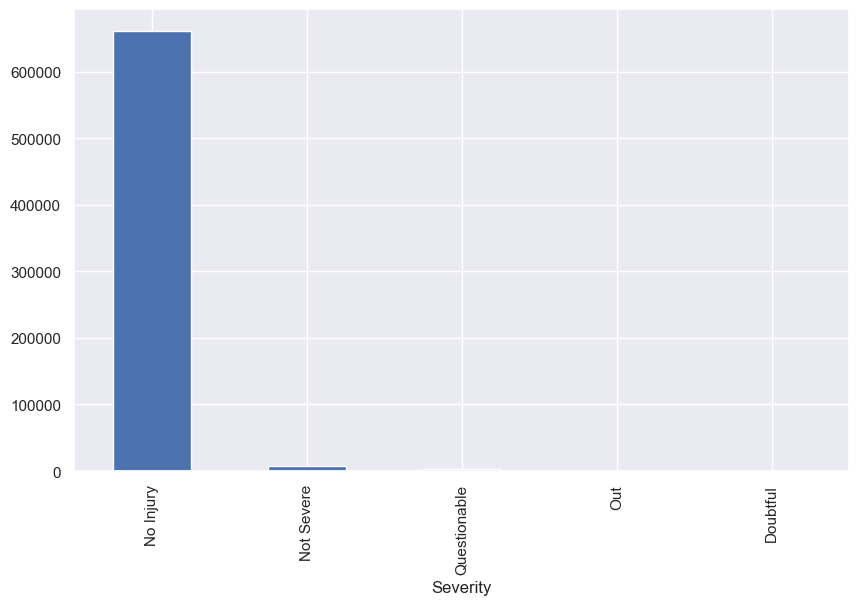

In [ ]:
combined_data['Severity'].value_counts().plot(kind='bar', figsize=(10, 6))

Now we will begin selecting the data for analysis

In [ ]:
training_data = combined_data #[~combined_data['Severity'].isin(['No Injury'])]

In [ ]:
y = training_data['Injury']


In [ ]:
# train_numeric = training_data[['week','qtr', 'down', 'ydstogo','yardline_100','spread_line',
#                     'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback',
#                     'qb_scramble','season','overtime', 'div_game', 'wind', 'temp', 'score_differential']]

# train_str = training_data[['game_half',
#                     'play_type',
#                     'pass_length','pass_location',
#                     'run_location', 'run_gap','weekday','roof', 
#                     'surface','stadium', 'Severity']]
# pd.concat([train_numeric, train_str, y], axis=1).to_csv('../data/processed/NFL_verse_training_data.csv', index=False)

In [ ]:
train_numeric = training_data[['shotgun', 'qb_dropback', 'div_game', 'temp', 'wind', 'qtr', 'down', 'ydstogo']]

train_str = training_data[['run_gap', 'run_location', 'roof', 'pass_location', 'pass_length', 'surface', 'game_half', 'play_type', 'Severity','weekday']]

Endode the categorical variables and scale the numerical variables

In [ ]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA()
le = LabelEncoder()
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca) 

for feat in train_str:
    train_str[feat] = le.fit_transform(train_str[feat].astype(str))

for feat in train_numeric:
    train_numeric[feat].fillna(train_numeric[feat].mean(), inplace=True)

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_52740/3165086785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_str[feat] = le.fit_transform(train_str[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_52740/3165086785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_str[feat] = le.fit_transform(train_str[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_52740/3165086785.py:12: SettingWithCopyWarning: 
A value is trying 

In [ ]:
X_enc = pipeline.fit_transform(pd.concat([train_numeric, train_str], axis=1))

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, random_state=41)

In [ ]:
# df_processed = pd.DataFrame(
#     data=X_enc, 
#     index=pd.concat([train_numeric, train_str], axis=1).index, 
#     columns=pd.concat([train_numeric, train_str], axis=1).columns
# )

In [ ]:
from sklearn.linear_model import LinearRegression


linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression()

In [ ]:
#See the R-Squared
from sklearn.metrics import precision_score, recall_score


score = linr.score(X_test, y_test)
print("R-squared: {:.2f}".format(score))

#Now test the model
y_pred = linr.predict(X_test)
print('Training Set:', linr.score(X_train,y_train))
print('Test Set:', linr.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
# print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred, average='macro')*100))
# print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred, average='macro')*100))


R-squared: 0.73
Training Set: 0.7295782198945571
Test Set: 0.7281181187817802


Information gain

In [ ]:
from sklearn.feature_selection import mutual_info_classif

combined_data = pd.concat([train_numeric, train_str], axis=1)
ig = mutual_info_classif(combined_data, y, random_state=42)
ig

array([0.08534521, 0.07863707, 0.04620804, 0.03194509, 0.03517583,
       0.03326738, 0.0376993 , 0.04541065, 0.09490007, 0.09320902,
       0.09261207, 0.08504256, 0.05728373, 0.05337007, 0.05283385,
       0.05075593, 0.26223746, 0.10356609])

In [ ]:
# Create a dictionary to store the feature and its information gain
ig_dict = {}
for i in range(len(combined_data.columns)):
    ig_dict[combined_data.columns[i]] = ig[i]

In [ ]:
ig_dict_sorted = dict(sorted(ig_dict.items(), key=lambda item: item[1], reverse=True))

# Select the top n features with the highest information gain
n = 10
selected_features = list(ig_dict_sorted.keys())[:n]

# Print the selected features
print('Selected Features:')
print(selected_features)

Selected Features:
['Severity', 'weekday', 'run_gap', 'run_location', 'roof', 'shotgun', 'pass_location', 'qb_dropback', 'pass_length', 'surface']


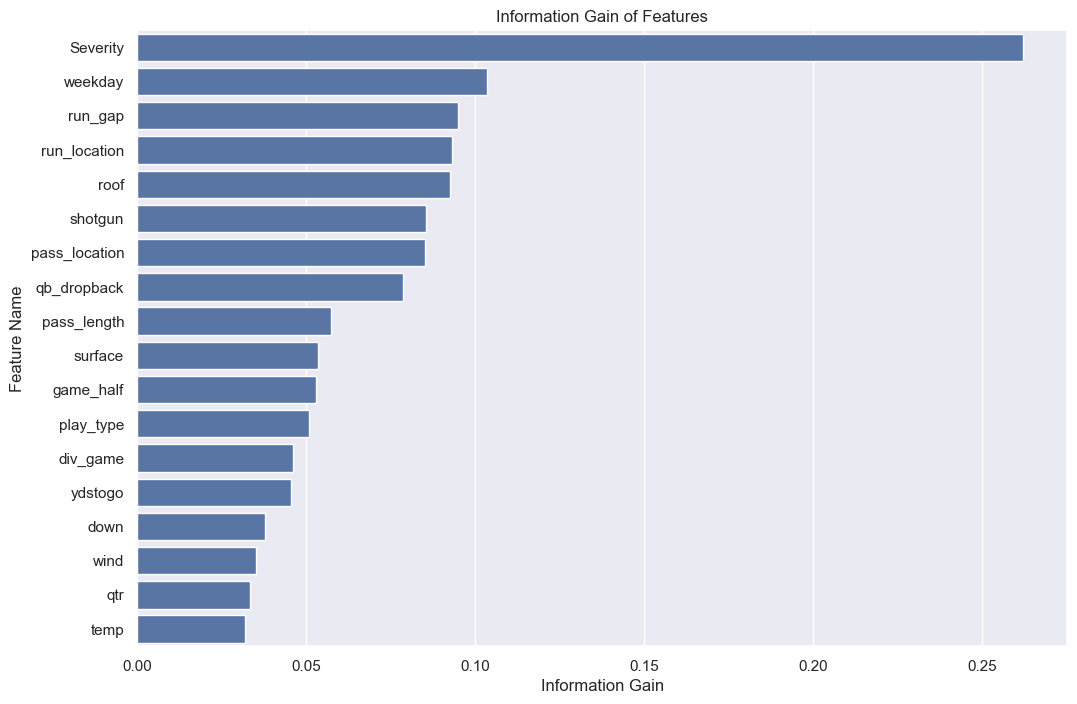

In [ ]:
# Visualize the information gain of each feature
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=list(ig_dict_sorted.values()), y=list(ig_dict_sorted.keys()))
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')
plt.show()

In [ ]:
pd.concat([train_numeric, train_str, y], axis=1).to_csv('../data/processed/NFL_verse_training_data.csv', index=False)